样本量(合并后): 121
样本量(变换后): 120

===== OLS with Newey-West (HAC) standard errors =====
                             OLS Regression Results                            
Dep. Variable:     unemployment_change   R-squared:                       0.372
Model:                             OLS   Adj. R-squared:                  0.366
Method:                  Least Squares   F-statistic:                     38.34
Date:                 Wed, 28 Jan 2026   Prob (F-statistic):           8.94e-09
Time:                         15:41:09   Log-Likelihood:                -442.02
No. Observations:                  120   AIC:                             888.0
Df Residuals:                      118   BIC:                             893.6
Df Model:                            1                                         
Covariance Type:                   HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

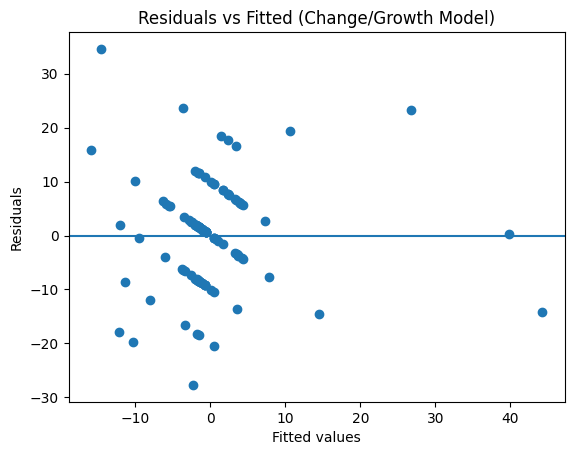

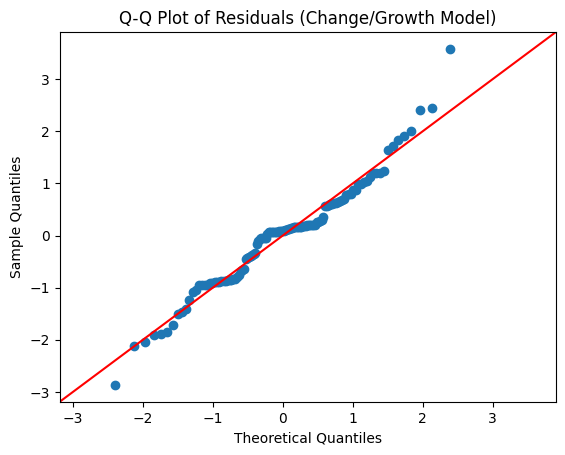

Shapiro-Wilk test:
Statistic = 0.972, p-value = 0.013
Spearman correlation (growth/change):
rho = -0.505, p-value = 0.000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# =============================
# 1. 读取数据
# =============================
unemp = pd.read_csv(
    "using_data_csv/失业率（15-25）.csv",
    parse_dates=["date"]
).rename(columns={"rate": "unemployment"})

vac = pd.read_csv(
    "using_data_csv/职位空缺（15-25）.csv",
    parse_dates=["date"]
).rename(columns={"value": "vacancies"})

# =============================
# 2. 按时间合并 + 排序
# =============================
df = pd.merge(unemp, vac, on="date", how="inner").dropna()
df = df.sort_values("date").reset_index(drop=True)

print(f"样本量(合并后): {len(df)}")

# =============================
# 3. 构造“变化/增长”变量（修正时间序列问题）
# 方案：vacancies 用增长率；unemployment 用月度变化
# =============================
df["vacancies_growth"] = df["vacancies"].pct_change() * 100      # 百分比：% MoM
df["unemployment_change"] = df["unemployment"].diff() * 100          # 失业率：百分点变化

df_ts = df.dropna().copy()  # 去掉第一行的 NaN
print(f"样本量(变换后): {len(df_ts)}")

# =============================
# 4. 构建二元回归模型（变化对变化）
# unemployment_change = β0 + β1 * vacancies_growth
# =============================
X = df_ts[["vacancies_growth"]]
X = sm.add_constant(X)
y = df_ts["unemployment_change"]

model = sm.OLS(y, X).fit()
#print(model.summary())

# （可选但强烈建议）HAC/Newey-West稳健标准误：应对剩余自相关
model_hac = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 6})
print("\n===== OLS with Newey-West (HAC) standard errors =====")
print(model_hac.summary())

# =============================
# 5. 残差诊断（模型可靠性验证）
# =============================

# 5.1 残差 vs 拟合值
plt.figure()
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Change/Growth Model)")

# 保存图片
plt.savefig(
    "pic/Residuals vs Fitted_1.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

# 5.2 残差正态性（Q-Q plot）
resid_std = (model.resid - model.resid.mean()) / model.resid.std()
sm.qqplot(resid_std, line="45")
plt.title("Q-Q Plot of Residuals (Change/Growth Model)")

plt.savefig(
    "pic/Q-Q Plot of Residuals_1.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

# 5.3 Shapiro-Wilk 正态性检验
shapiro_test = stats.shapiro(model.resid)
print("Shapiro-Wilk test:")
print(f"Statistic = {shapiro_test.statistic:.3f}, p-value = {shapiro_test.pvalue:.3f}")

# =============================
# 6. Spearman相关（对变化变量做）
# =============================
spearman_corr = stats.spearmanr(df_ts["vacancies_growth"], df_ts["unemployment_change"])
print("Spearman correlation (growth/change):")
print(f"rho = {spearman_corr.correlation:.3f}, p-value = {spearman_corr.pvalue:.3f}")


/var/folders/fk/f1mjs7z94bx25kz_8b8jyp7c0000gn/T/ipykernel_33530/1581514915.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]          # const
/var/folders/fk/f1mjs7z94bx25kz_8b8jyp7c0000gn/T/ipykernel_33530/1581514915.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]              # vacancies_growth 的系数
/var/folders/fk/f1mjs7z94bx25kz_8b8jyp7c0000gn/T/ipykernel_33530/1581514915.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

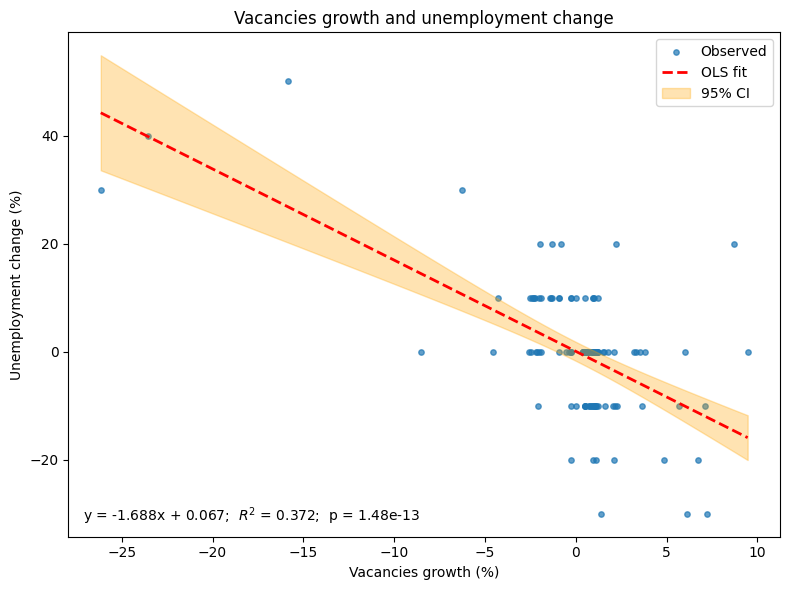

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 自变量 / 因变量
x = df_ts["vacancies_growth"].values
y = df_ts["unemployment_change"].values

# 用于画拟合线的 x
x_grid = np.linspace(x.min(), x.max(), 200)
X_grid = sm.add_constant(x_grid)

# 预测值 + 95% 置信区间
pred = model.get_prediction(X_grid).summary_frame(alpha=0.05)

# 画图
plt.figure(figsize=(8, 6))

plt.scatter(x, y, alpha=0.7, label="Observed", s=15)

plt.plot(
    x_grid,
    pred["mean"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="OLS fit"
)

plt.fill_between(
    x_grid,
    pred["mean_ci_lower"],
    pred["mean_ci_upper"],
    color="orange",
    alpha=0.3,
    label="95% CI"
)

plt.xlabel("Vacancies growth (%)")
plt.ylabel("Unemployment change (%)")
plt.title("Vacancies growth and unemployment change")
plt.legend()
# =============================
# 左下角显示回归方程 + p值
# =============================
# 从你已经 fit 好的 model 里拿系数和p值
intercept = model.params[0]          # const
slope = model.params[1]              # vacancies_growth 的系数
pval = model.pvalues[1]              # vacancies_growth 的 p 值
r2 = model.rsquared                  # 可选：R^2

# 组装文本（想更短可以删掉 R^2 那行）
eq_text = (
    f"y = {slope:.3f}x + {intercept:.3f};  "
    f"$R^2$ = {r2:.3f};  "
    f"p = {pval:.3g}"
)

# 放在左下角（axes fraction 坐标：0~1）
plt.gca().text(
    0.02, 0.02, eq_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    va="bottom", ha="left",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="none")
)
plt.tight_layout()

# 保存图片
plt.savefig(
    "pic/Vacancies growth and unemployment change.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
